In [ ]:
#Student Name: Nianchuer Liu
#Student Number: 1010332454
#Email:nianchuer.liu@mail.utoronto.ca
import pandas as pd
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

file_path = 'INF2178_A2_data.xlsx'
data = pd.read_excel(file_path)

data.head()


,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,Y
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,Y
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,Y
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,15,40,0,0,65,Y,Y
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,10,16,0,0,26,Y,Y


In [ ]:
from scipy.stats import shapiro, levene
import matplotlib.pyplot as plt
import seaborn as sns

# Test for normality and homogeneity of variances for TOTSPACE based on AUSPICE

# Normality test
normality_test_results = shapiro(data['TOTSPACE'])
groups = data.groupby('AUSPICE')['TOTSPACE'].apply(list)

# Levene's test for homogeneity of variances
homogeneity_test_results = levene(*groups)

normality_test_results, homogeneity_test_results


(ShapiroResult(statistic=0.884463369846344, pvalue=2.025148462518222e-27),
 LeveneResult(statistic=17.927068524236084, pvalue=2.2036889276494363e-08))

In [ ]:
# Importing necessary libraries for the analysis
import numpy as np
from scipy import stats


data['LOG_TOTSPACE'] = np.log1p(data['TOTSPACE'])
normality_log_transformed = {auspice: stats.shapiro(group['LOG_TOTSPACE'].sample(min(50, len(group))))
                             for auspice, group in data.groupby('AUSPICE')}
levene_log_transformed = stats.levene(*[group['LOG_TOTSPACE'].values for name, group in data.groupby('AUSPICE')])

normality_log_transformed, levene_log_transformed.statistic, levene_log_transformed.pvalue


({'Commercial Agency': ShapiroResult(statistic=0.9346346855163574, pvalue=0.00831097736954689),
  'Non Profit Agency': ShapiroResult(statistic=0.9827865958213806, pvalue=0.6738656163215637),
  'Public (City Operated) Agency': ShapiroResult(statistic=0.9435030817985535, pvalue=0.049749091267585754)},
 5.73946065579924,
 0.0033172922838112877)

In [ ]:
f_value, p_value = stats.f_oneway(*[group['LOG_TOTSPACE'].dropna().values for name, group in data.groupby('AUSPICE')])
welch_anova_result = {"F": f_value, "p-value": p_value}

welch_anova_result

{'F': 18.560113600948736, 'p-value': 1.195008237571607e-08}

In [ ]:
# Fitting the model for two-way ANOVA on the transformed data (LOG_TOTSPACE) with AUSPICE and ward
model_log_transformed = ols('LOG_TOTSPACE ~ C(AUSPICE) + C(ward) + C(AUSPICE):C(ward)', data=data).fit()

# Performing two-way ANOVA
two_way_anova_log_transformed_results = sm.stats.anova_lm(model_log_transformed, typ=2)

two_way_anova_log_transformed_results


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 18
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(AUSPICE),13.774167,2.0,18.748669,1.017142e-08
C(ward),11.661436,24.0,1.322744,1.645062e-01
C(AUSPICE):C(ward),16.944786,48.0,0.961014,5.433195e-01
Residual,365.133183,994.0,NaN,NaN


<ipython-input-16-beaa7002ab2b>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  interaction_plot.set_xticklabels(interaction_plot.get_xticklabels(), rotation=45, ha="right")


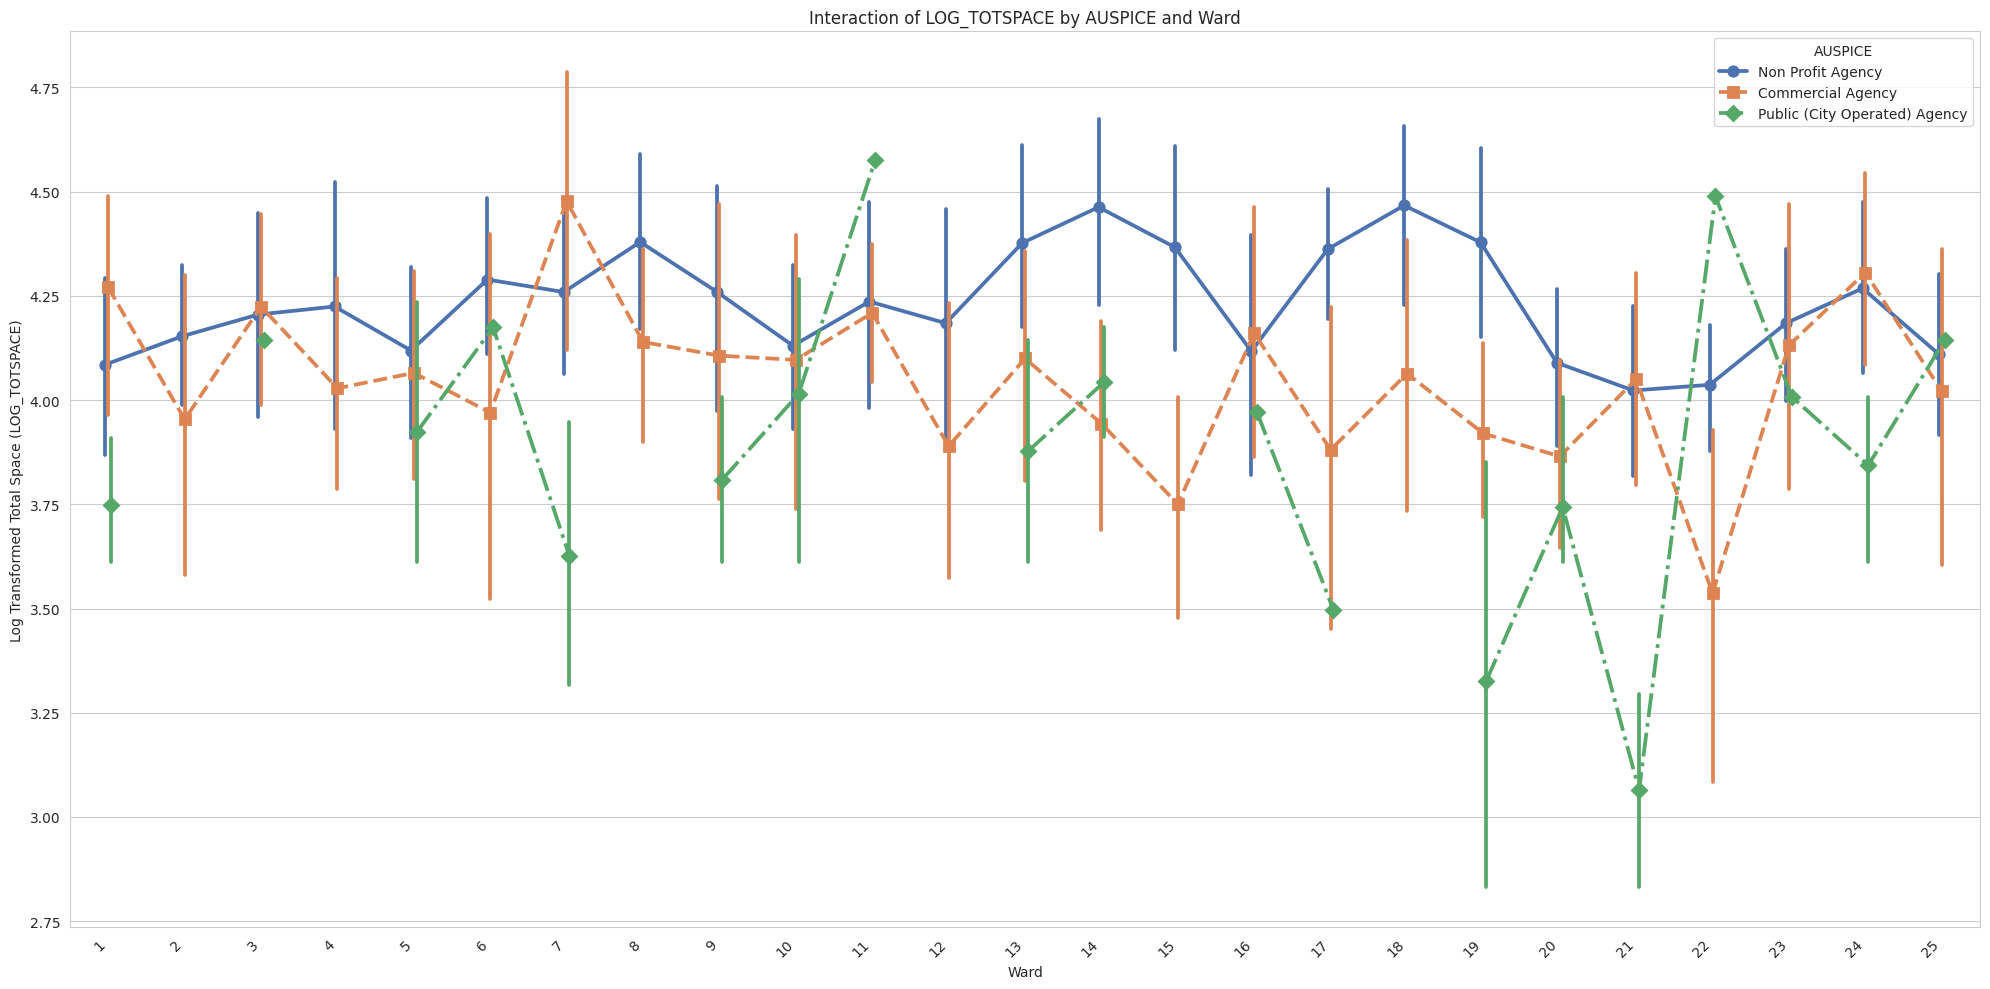

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

interaction_plot = sns.pointplot(data=data, x='ward', y='LOG_TOTSPACE', hue='AUSPICE',
                                 palette='deep', dodge=True, markers=["o", "s", "D"],
                                 linestyles=["-", "--", "-."])

interaction_plot.set_title('Interaction of LOG_TOTSPACE by AUSPICE and Ward')
interaction_plot.set_xlabel('Ward')
interaction_plot.set_ylabel('Log Transformed Total Space (LOG_TOTSPACE)')
interaction_plot.set_xticklabels(interaction_plot.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.legend(title='AUSPICE')
plt.show()


In [ ]:
# For post-hoc tests, we'll use Tukey's HSD to compare means of LOG_TOTSPACE across different AUSPICE categories
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Post-hoc test for AUSPICE on LOG_TOTSPACE
post_hoc_results = pairwise_tukeyhsd(data['LOG_TOTSPACE'], data['AUSPICE'], alpha=0.05)

# Display the results
print(post_hoc_results)


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
      group1                  group2            meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------
Commercial Agency             Non Profit Agency   0.2015    0.0  0.1055  0.2974   True
Commercial Agency Public (City Operated) Agency  -0.2161 0.0902 -0.4576  0.0253  False
Non Profit Agency Public (City Operated) Agency  -0.4176 0.0001 -0.6518 -0.1833   True
--------------------------------------------------------------------------------------
